In [288]:
import numpy as np
import pandas as pd
import csv
import math
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB, MultinomialNB,BernoulliNB
from sklearn import metrics, svm
from sklearn.svm import SVR
from sklearn.metrics import roc_curve, roc_auc_score, mutual_info_score, accuracy_score, mean_squared_error, r2_score, explained_variance_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV, ElasticNet,ElasticNetCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.model_selection import ShuffleSplit
from scipy import stats
from sklearn.utils import resample

%matplotlib inline

In [256]:
# Function to check that there is a float or integer valued string
# Cite the following website: http://pythoncentral.io/how-to-check-if-a-string-is-a-number-in-python-including-unicode/#
def is_number(s):
   
    try:
        float(s)
        return True
    except ValueError:
        pass

    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass
   
    return False

    if(math.isnan(s)):           # ensure that NA term is regarded as false
        return False



print(is_number('hispanic'))    # just a sanity check

False


In [257]:
df=pd.read_csv('fragilefamilieschallenge/background_2.csv', sep=',',header=None, dtype = str)  # imputed data of 4242 families
background_data = df.values
M,N = background_data.shape
M,N

(4243, 11880)

In [258]:
challenge_ID = (background_data[1:,N-1])           # challenge ID in the background file (do not consider 'idnum')
background_features = background_data[1:,2:N-1]    # Holds the features given in the background.csv file
                                                   # Exclude the 'momID' column entry in the feature set.

In [259]:
#Impute the 'NA' entries with a -1000.0

for i in range(M-1):
    for j in range(N-3):
        if(is_number(background_features[i,j])==False or math.isnan(float(background_features[i,j]))==True):     # Ensure that all values labelled as "other" are replaced by a 1.0
            background_features[i,j]=-1000.0
        else:
            background_features[i,j]=float(background_features[i,j])
            #print(background_features[i,j])
                
background_features=background_features.astype(np.float)  # ensure that each entry is float data type
            


In [260]:
# Actual imputation of NA with the average of the column

imp= Imputer(missing_values=-1000,strategy='mean', axis=0)
background_features=imp.fit_transform(background_features)

In [261]:
train_data = np.genfromtxt('fragilefamilieschallenge/train.csv', delimiter = ',')
P,Q = train_data.shape
train_ID = train_data[1:,0]                        # Challenge ID of the family in training set
train_outcome = train_data[1:,1:]                  # The 6 outcomes at age 15
                                                   # Need to impute the training outcome for the 6 outcomes as
                                                   # some values are missing

x = train_outcome[:,0]
Z=np.count_nonzero(~np.isnan(x))   # no. of valid entries for the outcome 'GPA'

In [262]:
# training for GPA:

pca = PCA(n_components=1000,svd_solver='auto')                   # first do dimensionality reduction
                                                                 # Also stndardize the data before PCA
background_features_pca = pca.fit_transform(StandardScaler().fit_transform(background_features)) 
size = background_features_pca.shape[1]

train_feature = np.zeros((P-1,size))                # stores the features for the total training data for GPA
test_feature = np.zeros((P-1,size))                 # stores the features for the 2121 test data points
                                                   # same size as train_feature
gpa_train = np.zeros((Z,))        # stores the training GPA data for valid entries

miss_feature = np.zeros((P-1-Z,size))    # missing entries' features for GPA
avail_feature = np.zeros((Z,size))   # valid entries' features for GPA

In [263]:
k = 0
t = 0

for i in range(P-1):
    for j in range(M-1):
        if(float(challenge_ID[j]) == train_ID[i]):        # match the train_ID with the ID in background.csv file to get the corresponding features
            train_feature[i,:] = (background_features_pca[j,:])
            if(math.isnan(train_outcome[i,0])==False):    # check for the valid entries with numerical GPA values
                gpa_train[k]= train_outcome[i,0]
                avail_feature[k,:]= background_features_pca[j,:]
                k = k +1
            else:
                miss_feature[t,:]= background_features_pca[j,:] 
                t= t +1
                
                    
        #else:
        #    test_feature[i,:] = (background_features[j,:])

print('done')

done


In [264]:
#pca = PCA(n_components=5000,svd_solver='auto')
#avail_feature_pca = pca.fit_transform(avail_feature)

clf = LassoCV(eps=1e-3, n_alphas=100,cv=5, max_iter=4000)
clf.fit(avail_feature, gpa_train)
pred = clf.predict(avail_feature)
err = mean_squared_error(gpa_train,pred)

In [265]:
print(np.unique(pred).shape)
print((err))
print(avail_feature.shape)
print(clf.coef_.shape)

(1165,)
0.347549914336
(1165, 1000)
(1000,)


In [266]:

#miss_feature_pca = pca.fit_transform(miss_feature)
pred_miss = clf.predict(miss_feature)


(70,)


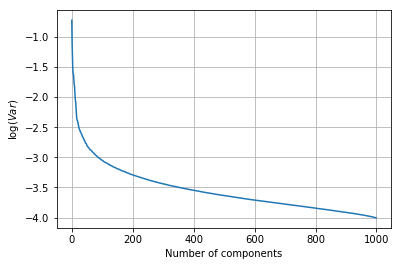

In [285]:
#print(np.unique(pred_miss).shape)
plt.plot(np.log10(pca.explained_variance_ratio_))  # plot of log variance for the 4242 features
plt.xlabel('Number of components')
plt.ylabel(r'$\log(Var)$')
plt.grid()
print(np.unique(clf.fit(avail_feature, gpa_train).coef_).shape)                  

var1=np.cumsum(np.round(pca.explained_variance_ratio_,decimals=4)*100)
#plt.plot(var1)

Here, we can see the no. of coefficients selected by the Lasso CV and also how the variance is distributed among the variance components of the PCA analysis which was used to select the appropriate value of n_components....

In [267]:
l = 0
train_outcome_new = train_outcome[:,0]  # the completed training label for GPA
for i in range(P-1):
    if(math.isnan(train_outcome[i,0])==True):
        train_outcome_new[i] = pred_miss[l]
        l = l+1
        

In [268]:
clf.fit(train_feature, train_outcome_new)
pred_new = clf.predict(train_feature)
err_new = mean_squared_error(train_outcome_new,pred_new)

print(err_new)

0.18426703718


In [278]:
# Elastic Net regression:

#elas = ElasticNet(l1_ratio=0.001)
elas = ElasticNetCV(l1_ratio=0.001,eps=0.001, n_alphas=1000)
elas.fit(train_feature, train_outcome_new)
pred_elas = elas.predict(train_feature)
err_elas = mean_squared_error(train_outcome_new,pred_elas)
print(err_elas)

0.18502354727


In [281]:
# Support Vector Regression:

svr = SVR()
svr.fit(train_feature, train_outcome_new)
pred_svr = svr.predict(train_feature)
mean_squared_error(train_outcome_new,pred_svr)

0.014034955235394962

In [292]:
# R^2 calculation:

r2_score(train_outcome_new,pred_elas)
r2_score(train_outcome_new,pred_svr)
r2_score(train_outcome_new,pred_new)
explained_variance_score(train_outcome_new,pred_elas)
explained_variance_score(train_outcome_new,pred_svr)
explained_variance_score(train_outcome_new, pred_new)


ValueError: coef_ is only available when using a linear kernel

In [191]:
# bootstrapping
data = np.concatenate((train_feature,train_outcome_new[:,np.newaxis]),axis=1)
rs = ShuffleSplit(n_splits=100,test_size=0.1) 

indices= r.split(train_feature, train_outcome_new)
elas_boot = ElasticNet(l1_ratio=0.001)

err_elas_boot = np.zeros((100,1))  # same size as no. of splits
i=0

for train_index, test_index in rs.split(data):
    #print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
    #boot_train_data = resample(data[train_index])
    #boot_train_outcome = boot_train_data[:,-1:]
    #boot_train_feature = boot_train_data[:,:-1]
    
    #boot_test_data = resample(data[test_index])
    #boot_test_outcome = boot_test_data[:,-1:]
    #boot_test_feature = boot_test_data[:,:-1]
    #elas_boot.fit(boot_train_feature, boot_train_outcome)
    #err_elas_boot[i] = mean_squared_error(boot_test_outcome,elas_boot.predict(boot_test_feature))
    #i = i+1
    elas_boot.fit(train_feature[train_index], train_outcome_new[train_index])
    err_elas_boot[i] = mean_squared_error(train_outcome_new[test_index],elas_boot.predict(train_feature[test_index]))
    i =i +1              

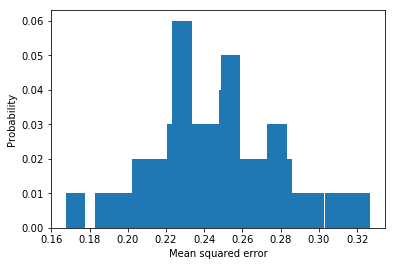

In [192]:
numbins =100
#plt.hist(err_elas_boot,bins=numbins,ec='k')
#plt.show()

width = 1.0/numbins
hist, bins = np.histogram(err_elas_boot,bins=numbins)
pdf = hist.astype(float)/hist.sum()

plt.figure()
plt.bar(bins[0:numbins],pdf,width)
plt.xlabel('Mean squared error')
plt.ylabel('Probability')

In [193]:
stats.bayes_mvs(err_elas_boot, alpha=0.95)

(Mean(statistic=0.24483253951281547, minmax=(0.23893086900102262, 0.25073421002460833)),
 Variance(statistic=0.00090289046748055941, minmax=(0.00068197336196456119, 0.0011938261421077065)),
 Std_dev(statistic=0.029970793272213147, minmax=(0.026114619697873473, 0.034551789275053563)))

In [102]:
np.var(StandardScaler().fit_transform(background_features))

0.80713954566527446

In [300]:
l = 0
test_ID = np.zeros((P-1,1))
for i in range(M-1):
    check = 0 
    for j in range(P-1):
        if(float(challenge_ID[i]) != train_ID[j]):        # match the train_ID with the ID in background.csv file to get the corresponding features
            check = check +1
    if(check == P-1):        
        test_feature[l,:] = (background_features_pca[i,:])
        test_ID[l,:] = challenge_ID[i]
        l=l+1
            

In [298]:
final_pred = svr.predict(test_feature)
np.unique(final_pred).shape

(2119,)

In [299]:
np.savetxt("foo.csv", final_pred, delimiter=",")

In [307]:
Z = np.concatenate((train_ID[:,np.newaxis],pred_svr[:,np.newaxis]),axis=1)
T = np.concatenate((test_ID,pred_svr[:,np.newaxis]),axis=1)

F = np.concatenate((Z,T),axis=0)

np.savetxt("foo.csv", F, delimiter=",")

In [318]:
np.unique(clf.coef_).shape


(94,)